In [1]:
##### CHANGE THESE VARIABLES #####

# Local spatial reference to the area of interest
# Lookup here: https://spatialreference.org/ref/epsg/
EPSG_LOCAL = 32617 

# Path and file name of the SARTopo export containing the segment and the search gps tracks
# Use double backspaces in the path
FILE_PATH = ".\\"
FILE_NAME = "track-intersects.json"

# Use Imperial units

SEARCHERS = 5
SEARCHER_SPEED = 0.5
SEARCH_TIME = 5.6
ESW = 35

##### RUN, BUT DO NOT CHANGE BELOW THIS FRAME #####

In [2]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

# WGS84 spatial reference - This is what SARTopo uses
EPSG_WGS84 = 4326

# Read the SARTopo export containing the segment and the search gps tracks
import_gdf = gp.read_file(FILE_PATH + FILE_NAME)

# Convert the export from WGS84 to the local spatial reference
import_gdf = import_gdf.to_crs(epsg=EPSG_LOCAL)


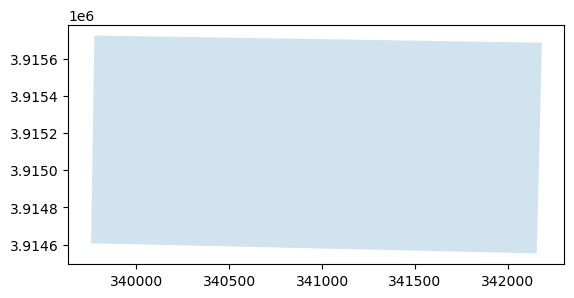

In [3]:

# Extract the polygon representing the search segment
segment_gdf = import_gdf[import_gdf.geometry.geom_type == 'Polygon']

# Remove extraneous data that comes from SARTopo.  Only interested in the 
# segment name (title) and the boundary (geometry)
segment_gdf = segment_gdf[['title', 'geometry']]


# For debugging, showing myself what the segment looks like
segment_gdf.plot(alpha=0.2)
plt.show()



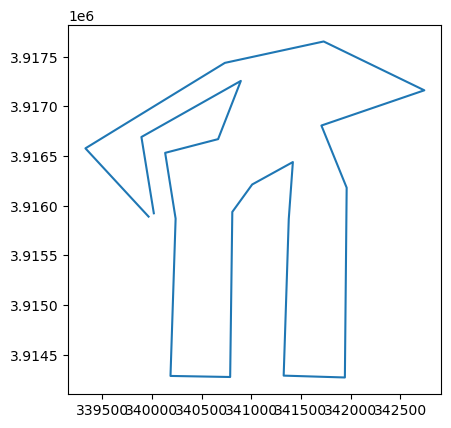

In [4]:

# Extract the search gps tracks
search_tracks_gdf = import_gdf[import_gdf.geometry.geom_type == 'LineString']
search_tracks_gdf = search_tracks_gdf[['title', 'geometry']]

# For debugging, showing myself what the gps tracks look like
search_tracks_gdf.plot()
plt.show()


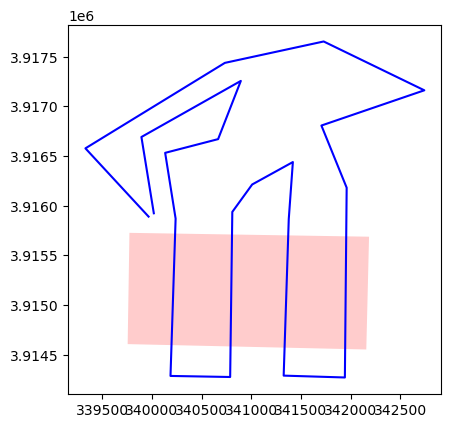

In [5]:
# And the two together
ax = segment_gdf.plot(color='red', alpha=0.2)
search_tracks_gdf.plot(color='blue', ax=ax)
plt.show()

In [6]:
# Create a list to hold the parts of the intersected search tracks
intersections = []

# Loop through each search segment
for segment_idx, segment in segment_gdf.iterrows():

    # Loop through each search track
    for track_idx, track in search_tracks_gdf.iterrows():
        # Intersect the search track with the segment
        intersected_track = track.geometry.intersection(segment.geometry)
        # Get the length of the intersected track
        intersected_length = intersected_track.length

        # Convert the intersected track to a GeoDataFrame
        intersected_track_gdf = gp.GeoDataFrame({'geometry': [intersected_track]}, crs=EPSG_LOCAL)

        # Split the multi-line string into individual line strings
        intersected_track_gdf = intersected_track_gdf.explode(index_parts=True)

        # Calculate statistics about the intersected track
        tl = intersected_length
        ttl = tl * SEARCHERS
        aes = ttl * ESW
        c = aes / segment.geometry.area

        # Print the data to the console
        print(f"TL within segment: {round(tl, 2)} (m) | {round(tl * 3.280839895)} (ft)")
        print(f"TTL within segment: {round(ttl, 2)} (m) | {round(ttl * 3.280839895)} (ft)")
        print(f"Area effectively searched: {round(aes,2)} (m) | {round(aes * 3.280839895, 2)} (ft)")
        print(f"Coverage: {round(c * 100, 2)}%")

        # Add the data to the 'description' column so it's imported back into SARTopo 
        intersected_track_gdf['description'] = f"TL within segment: {round(tl, 2)} (m) | {round(tl * 3.280839895)} (ft)\nTTL within segment: {round(ttl, 2)} (m) | {round(ttl * 3.280839895)} (ft)\nArea effectively searched: {aes} (m) | {aes * 3.280839895} (ft)\nCoverage: {round(c * 100, 2)}%"

        # Retain the title of the search track
        i = 1 
        for idx, row in intersected_track_gdf.iterrows():
            intersected_track_gdf.at[idx, 'title'] = f"{track.title} - {segment.title}{i}"
            i += 1
            
    
        # Append this intersected track to the list of intersected tracks
        intersections.append(intersected_track_gdf)
        
        
# Convert the list of intersected tracks to a single GeoDataFrame
intersections_gdf = gp.GeoDataFrame(pd.concat(intersections), crs=EPSG_LOCAL)
intersections_gdf.set_index('title', inplace=True)

TL within segment: 4514.52 (m) | 14811 (ft)
TTL within segment: 22572.61 (m) | 74057 (ft)
Area effectively searched: 790041.29 (m) | 2591998.99 (ft)
Coverage: 29.1%


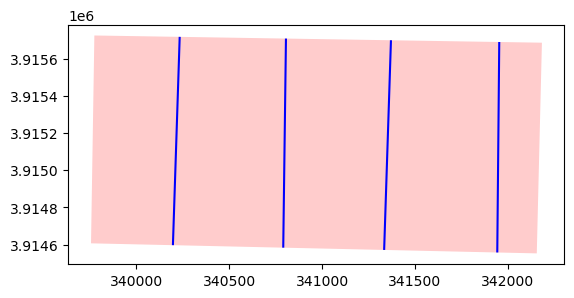

In [7]:
# For debugging, showing myself what the intersected tracks look like
ax = segment_gdf.plot(color='red', alpha=0.2)
intersections_gdf.plot(ax=ax, color='blue')
plt.show()

In [8]:
# Write the intersected tracks to a file
intersections_gdf.to_crs(epsg=EPSG_WGS84).to_file(FILE_PATH + "\\output_intersected.geojson", driver='GeoJSON')
print(f"Output written to {FILE_PATH}output_intersected.geojson")


Output written to .\output_intersected.geojson
